# Auswertung Schleppleistungsmessung

Folgendes Notebook wird verwendet um für verschiedene Traktortypen die Messdaten auszuwerten.

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats

In [5]:
# SELECT TRACTOR TO EVALUATE

TRACTOR = 'Fiat_56'
# TRACTOR = 'Fiat_1300_DT' # TODO: keine Motorbremse
# TRACTOR = 'NewhollandT5.140'
# TRACTOR = 'NewhollandT6.175'
# TRACTOR = 'NewhollandT6.180'
# TRACTOR = 'Huerlimann_D115'
# TRACTOR = 'Huerlimann_D210'

In [9]:
files = {
#     'Fiat_56': 'Fiat_fixed_extrapolated.csv', # Fiat_56_Schlepp_warm_motorenbremse_2023-03-31_10-30-37.xls', # mit Motorbremse
    'Fiat_56': 'fixed/Fiat_56_schlepp.csv',
    'Fiat_1300_DT': 'Fiat_1300DT_Schlepp_2023-03-31_11-55-40.xls',
    'NewhollandT6.180': 'NewhollandT6.180Schlepp_motorbremse_2023-04-06_14-47-06.xls', # mit Motorbremse
    'NewhollandT6.175': 'NewhollandT6.175Schlepp_Motorenbremse_2023-04-06_15-14-46.xls', # mit Motorbremse
    'NewhollandT5.140': 'NewhollandT5.140Schlepp_motorbremse_2023-04-06_14-12-14.xls', # mit Motorbremse
    'Huerlimann_D115': 'Hürlimannd115_Schlepp_2023-03-31_14-39-09.xls',
    'Huerlimann_D210': 'Hürlimannd210_schlepp_2023-03-31_13-57-29.xls'
}

files2 = {
    'Fiat_56': 'volllast/Volllastkennlinie_Fiat_56-66.csv',
    'Fiat_1300_DT': 'volllast/Volllastkennlinie_Fiat_1300.csv',
    'NewhollandT6.180': 'volllast/Volllastkennlinie_New_Holland_T6.180.csv',
    'NewhollandT6.175': 'volllast/Volllastkennlinie_New_Holland_T6.175.csv',
    'NewhollandT5.140': 'volllast/Volllastkennlinie_New_Holland_T5.140.csv',
    'Huerlimann_D115': 'volllast/Volllastkennlinie_Hürlimann_D_115.csv',
    'Huerlimann_D210': 'volllast/Volllastkennlinie_Hürlimann_D_210.csv'
}

# Fiat 1300 Super
# Fiat 56-66 
# Hürlimann D210 Synchromat
# Hürlimann D115 TA
names = {
    'Fiat_56': 'Fiat 56-66',
    'Fiat_1300_DT': 'Fiat 1300 Super',
    'NewhollandT6.180': 'NewhollandT6.180',
    'NewhollandT6.175': 'NewhollandT6.175',
    'NewhollandT5.140': 'NewholladnT5.140',
    'Huerlimann_D115': 'Hürlimann D115 TA',
    'Huerlimann_D210': 'Hürlimann D210 Synchromat'
}

if TRACTOR == 'Fiat_56':
    print("loading from special file")
    df = pd.read_csv(files[TRACTOR], sep="\t")
else:
    df = pd.read_excel(files[TRACTOR])
    
volllast = pd.read_csv(files2[TRACTOR])

loading from special file


In [10]:
df

,Unnamed: 0,Zeit,Ch1,RPM-Value
0,0,0.000000,-0.271608,424.005219
1,1,0.151028,-0.270930,424.005219
2,2,0.302057,-0.270591,424.005219
3,3,0.453085,-0.271269,424.005219
4,4,0.604113,-0.269913,424.005219
...,...,...,...,...
6152,6152,929.126230,-0.083076,782.778865
6153,6153,929.277259,-0.082737,782.778865
6154,6154,929.428287,-0.082737,782.778865
6155,6155,929.579315,-0.083415,782.778865


### Angleichung und Berechnung passender Werte
Ausgeglichen werden:
- Sensorungenauigkeit
- Konvertierung gemessener Volt am Sensor zu Drehzahl (RPM)
- Konvertierung von positiven zu negativen Werten für die Schleppleistung
- Umrechnung Übersetzungsverhältnis von Zapfwellendrehzahl (gemessen) zu Motordrehzahl
- Konvertierung des Datentyps zu Dezimal (float) und Ganzzahlen (integer)

In [11]:
# remove unused excel header rows
df = df.iloc[2:]

# sensor deviation factor, as sensor did not measure very correctly.
# using the first 20 values and match them to zero, as first readings should
# have been zero if sensor measured correctly.
SENSOR_DEVIATION_FACTOR = df['Ch1'].iloc[:20].mean()
df['Ch1'] = df['Ch1'] - SENSOR_DEVIATION_FACTOR

# convert Ch1 [Volt] to Newtonmeter
VOLT_TO_NEWTON_FACTOR = 299.2606857
df['Ch1'] = df['Ch1'] * VOLT_TO_NEWTON_FACTOR

# Convert Newtonmeter to negative, as its breaking force
df['Ch1'] = df['Ch1'] * (-1)

# RPM Conversion measured at measuring device converted to Motor mit Schlepp
# Schlepp: Zapfenwelle Grösse 1000er
RPM_RATIOS_SCHLEPP = {
    'Fiat_56': 3.066, # Zapfenwelle 750er
    'NewhollandT5.140': 2.0023,
    'NewhollandT6.175': 1.91,
    'NewhollandT6.180': 1.89,
    'Fiat_1300_DT': 2.1,
    'Huerlimann_D115': 2.0,
    'Huerlimann_D210': 2.0
}
df['RPM-Value-Motor'] = df['RPM-Value'] * RPM_RATIOS_SCHLEPP[TRACTOR]

# Convert Nm from Zapfwelle (PTO) to Nm Motor
df['Ch1'] = df['Ch1'] / RPM_RATIOS_SCHLEPP[TRACTOR]

# fix object to float types
df['Zeit'] = df['Zeit'].astype(float)
df['Ch1'] = df['Ch1'].astype(float)
df['RPM-Value'] = df['RPM-Value'].astype(int)
df['RPM-Value-Motor'] = df['RPM-Value-Motor'].astype(float)

df

/tmp/ipykernel_2023/2877919021.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Ch1'] = df['Ch1'] - SENSOR_DEVIATION_FACTOR
/tmp/ipykernel_2023/2877919021.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Ch1'] = df['Ch1'] * VOLT_TO_NEWTON_FACTOR
/tmp/ipykernel_2023/2877919021.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

,Unnamed: 0,Zeit,Ch1,RPM-Value,RPM-Value-Motor
2,2,0.302057,-0.039716,424,1300.0
3,3,0.453085,0.026478,424,1300.0
4,4,0.604113,-0.105910,424,1300.0
5,5,0.755142,-0.039716,424,1300.0
6,6,0.906170,-0.006619,424,1300.0
...,...,...,...,...,...
6152,6152,929.126230,-18.342331,782,2400.0
6153,6153,929.277259,-18.375428,782,2400.0
6154,6154,929.428287,-18.375428,782,2400.0
6155,6155,929.579315,-18.309235,782,2400.0


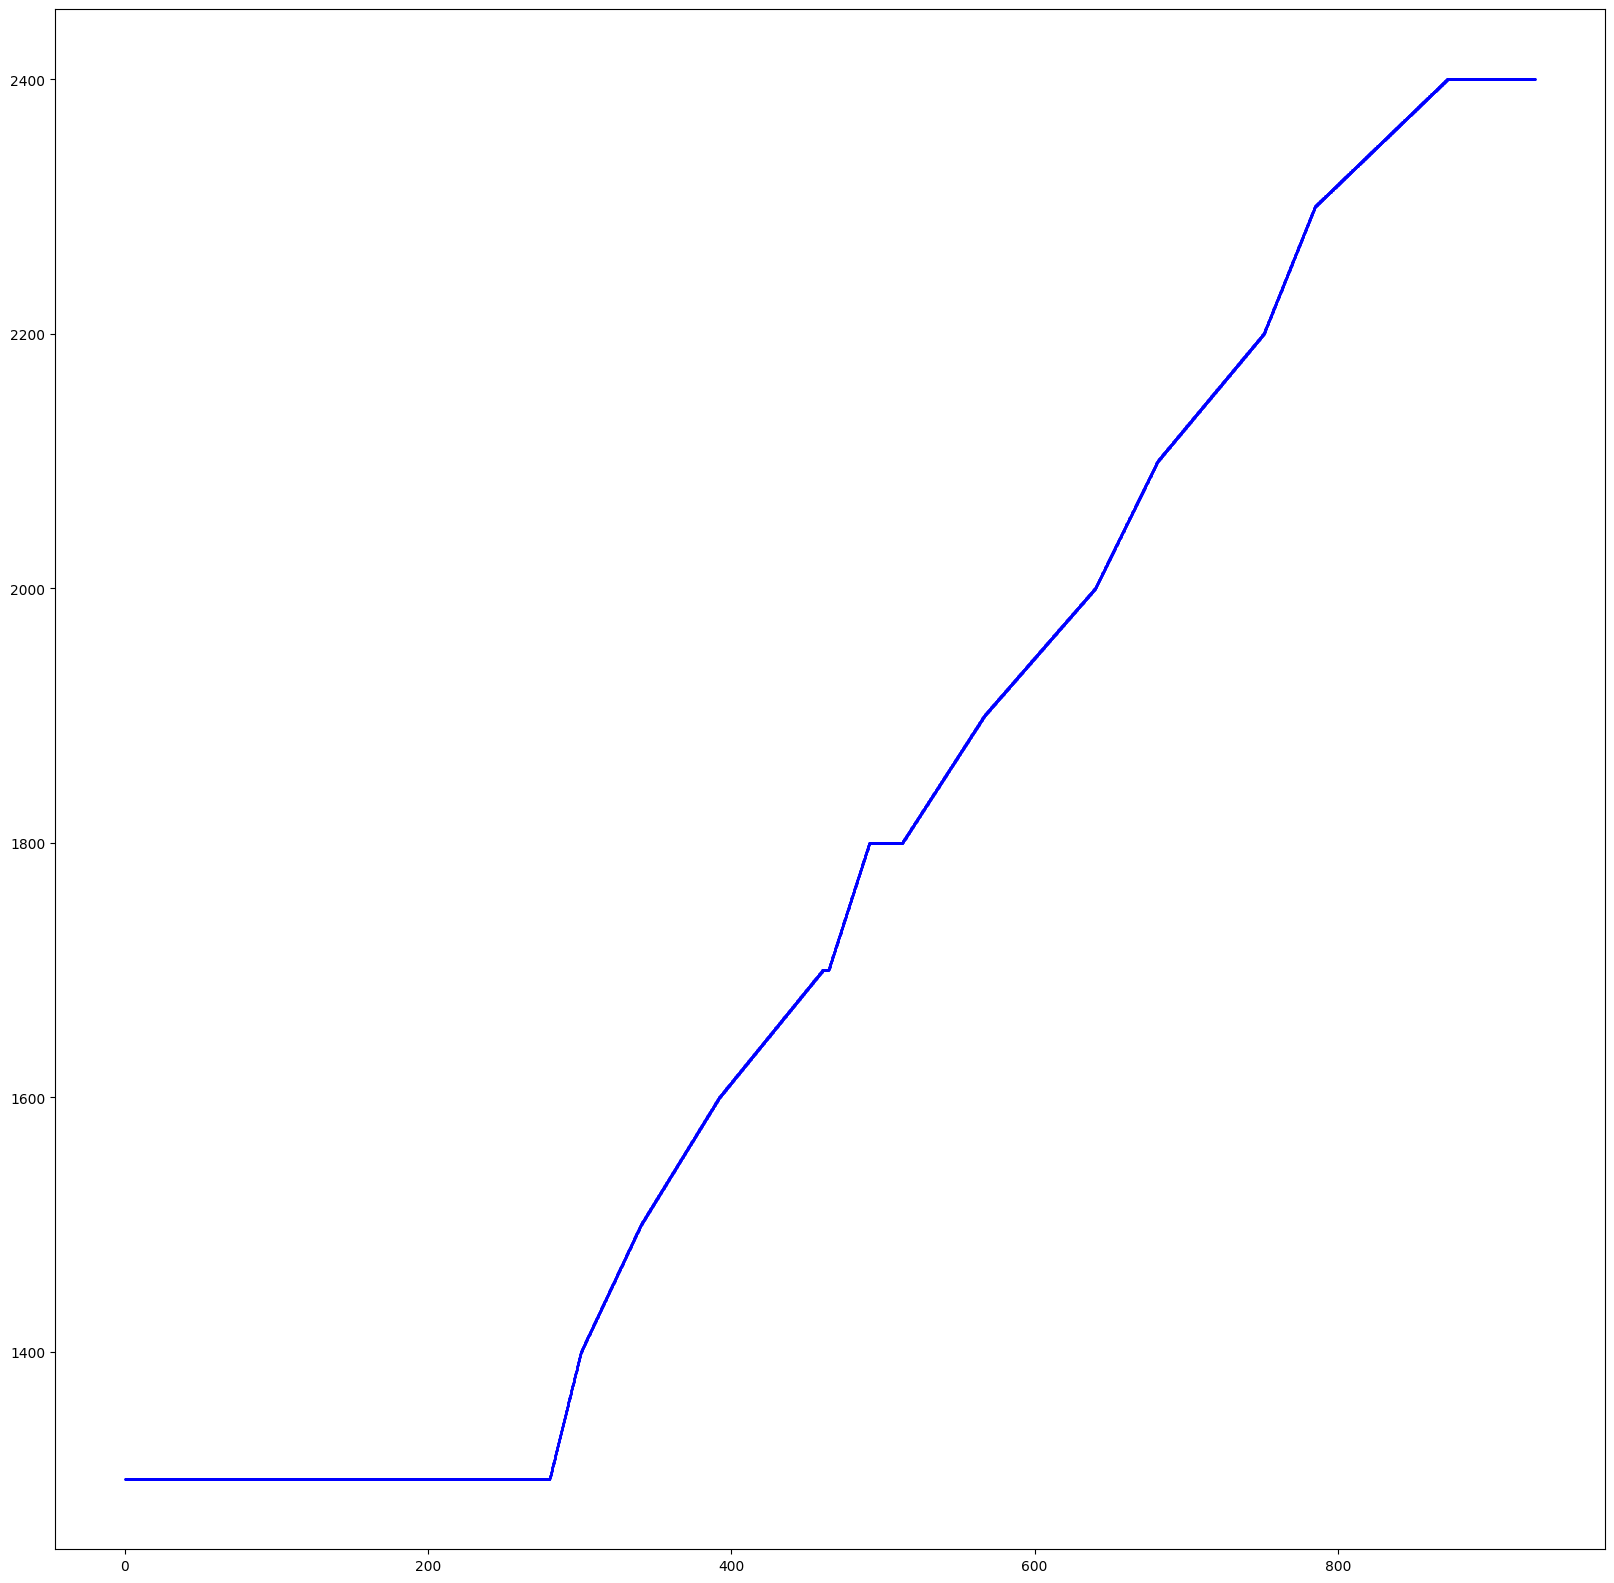

In [12]:
plt.figure(figsize=(20, 20))

# show all points
plt.scatter(data=df, x='Zeit', y='RPM-Value-Motor', color='blue', alpha=1, s=1, label='')

## Separation Schleppbremse und Normal

In [13]:
# save start and end for good plots, to remove long pre-/postfix data
ranges = {
    'Fiat_56': (250, 850),
    'NewhollandT6.180': (50, 450),
    'NewhollandT6.175': (40, 430),
    'NewhollandT5.140': (50, 660),
    'Fiat_1300_DT': (0, 5000),
    'Huerlimann_D115': (30, 560),
    'Huerlimann_D210': (0, 6000)
}
# define two points for each tractor to find a fitting separation line for the data
points = {
    'Fiat_56': ((0, -45), (800, -105)),
    'NewhollandT6.180': ((50, -190), (400, -320)),
    'NewhollandT6.175': ((50, -160), (400, -250)),
    'NewhollandT5.140': ((0, -125), (600, -250)),
    'Fiat_1300_DT': ((0, -100), (500, -350)),
    'Huerlimann_D115': ((100, 100), (500, 200)),
    'Huerlimann_D210': ((100, 100), (500, 200))
}
start, end = ranges[TRACTOR]
df = df[(df['Zeit'] > start) & (df['Zeit'] < end)]

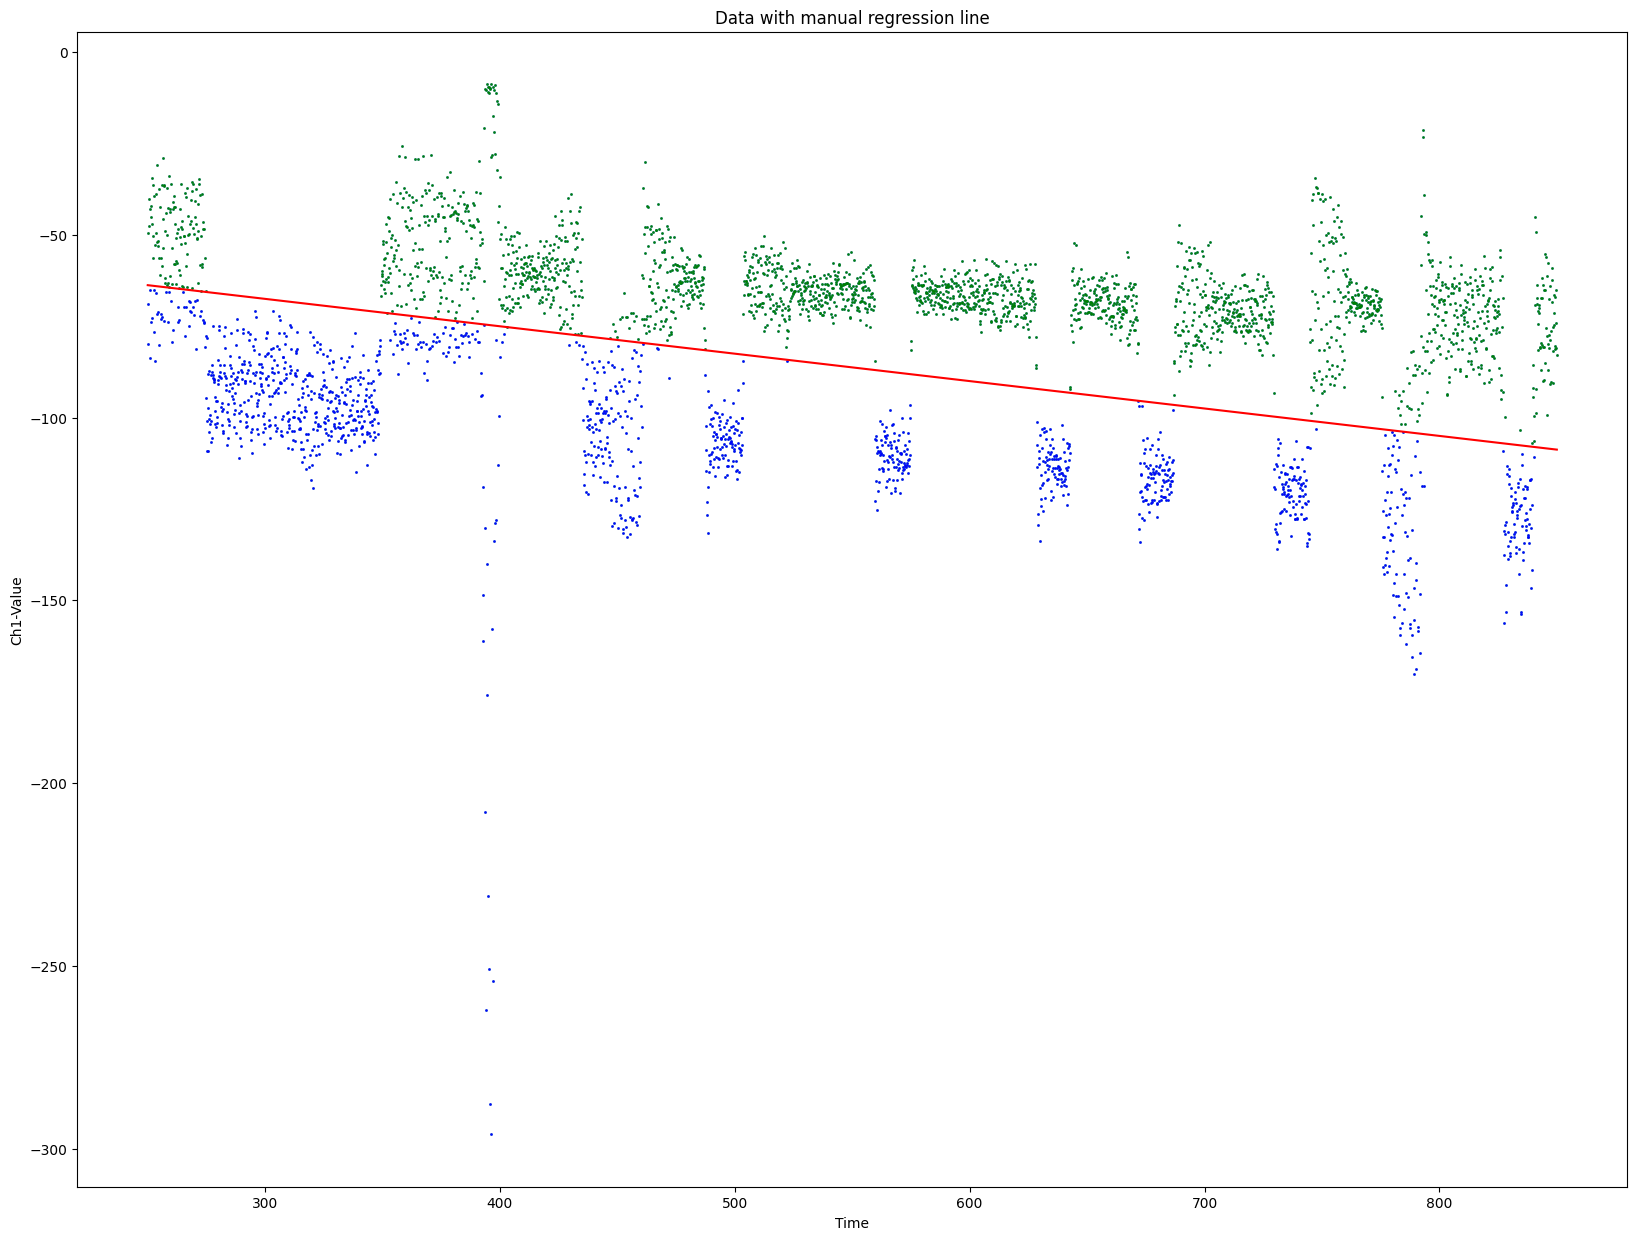

In [14]:
plt.figure(figsize=(20, 15))

point1, point2 = points[TRACTOR]

slope = (point2[1] - point1[1]) / (point2[0] - point1[0])
intercept = point1[1] - slope * point1[0]

#separate datapoints above and below regression line
above_line = df[df['Ch1'] >= slope * df['Zeit'] + intercept]
below_line = df[df['Ch1'] < slope * df['Zeit'] + intercept]

#visualize data and regression line
plt.scatter(df['Zeit'], df['Ch1'], alpha=0.8, s=1) # scatter plot of datapoints
plt.scatter(above_line['Zeit'], above_line['Ch1'], color='green', alpha=0.8, s=0.8) # scatter plot of points above regression line
plt.scatter(below_line['Zeit'], below_line['Ch1'], color='blue', alpha=0.8, s=0.8) # scatter plot of points below regression line
plt.plot(df['Zeit'], slope * df['Zeit'] + intercept, color='red') # line plot of regression line
plt.title("Data with manual regression line")
plt.xlabel("Time")
plt.ylabel("Ch1-Value")
plt.show()

# Plot Nm vs RPM Motor

In [15]:
df

,Unnamed: 0,Zeit,Ch1,RPM-Value,RPM-Value-Motor
1656,1656,250.102900,-49.453468,424,1300.000000
1657,1657,250.253928,-79.968859,424,1300.000000
1658,1658,250.404956,-68.980670,424,1300.000000
1659,1659,250.555984,-40.219418,424,1300.000000
1660,1660,250.707013,-47.666232,424,1300.000000
...,...,...,...,...,...
5624,5624,849.383277,-67.094144,774,2373.875433
5625,5625,849.534305,-65.174520,774,2374.048443
5626,5626,849.685334,-74.044504,774,2374.221453
5627,5627,849.836362,-80.895573,774,2374.394464


In [16]:
imprecise = ['Fiat_56']


if TRACTOR in imprecise:
    print("Removed Outliers")
    ### Above Line Filtering with Rolling Window

    # Set the window size and threshold for filtering
    window_size = 80
    threshold = 40

    # Sort the DataFrame by the x-axis values (assuming it's called 'x_column')
    above_line_sorted = above_line.sort_values(by='RPM-Value-Motor')

    # Calculate the rolling median for the 'RPM-Value-Motor' column
    above_line_sorted['rolling_median'] = above_line_sorted['Ch1'].rolling(window=window_size, center=True).median()

    # Filter out points more than the threshold away from the rolling median
    above_line_filtered = above_line_sorted[abs(above_line_sorted['Ch1'] - above_line_sorted['rolling_median']) <= threshold]

    # Remove the 'rolling_median' column
    above_line_filtered = above_line_filtered.drop(columns=['rolling_median'])


    ### Below Line Filtering with Rolling Window

    # Sort the DataFrame by the x-axis values (assuming it's called 'x_column')
    below_line_sorted = below_line.sort_values(by='RPM-Value-Motor')

    # Calculate the rolling median for the 'RPM-Value-Motor' column
    below_line_sorted['rolling_median'] = below_line_sorted['Ch1'].rolling(window=window_size, center=True).median()

    # Filter out points more than the threshold away from the rolling median
    below_line_filtered = below_line_sorted[abs(below_line_sorted['Ch1'] - below_line_sorted['rolling_median']) <= threshold]

    # Remove the 'rolling_median' column
    below_line_filtered = below_line_filtered.drop(columns=['rolling_median'])

Removed Outliers


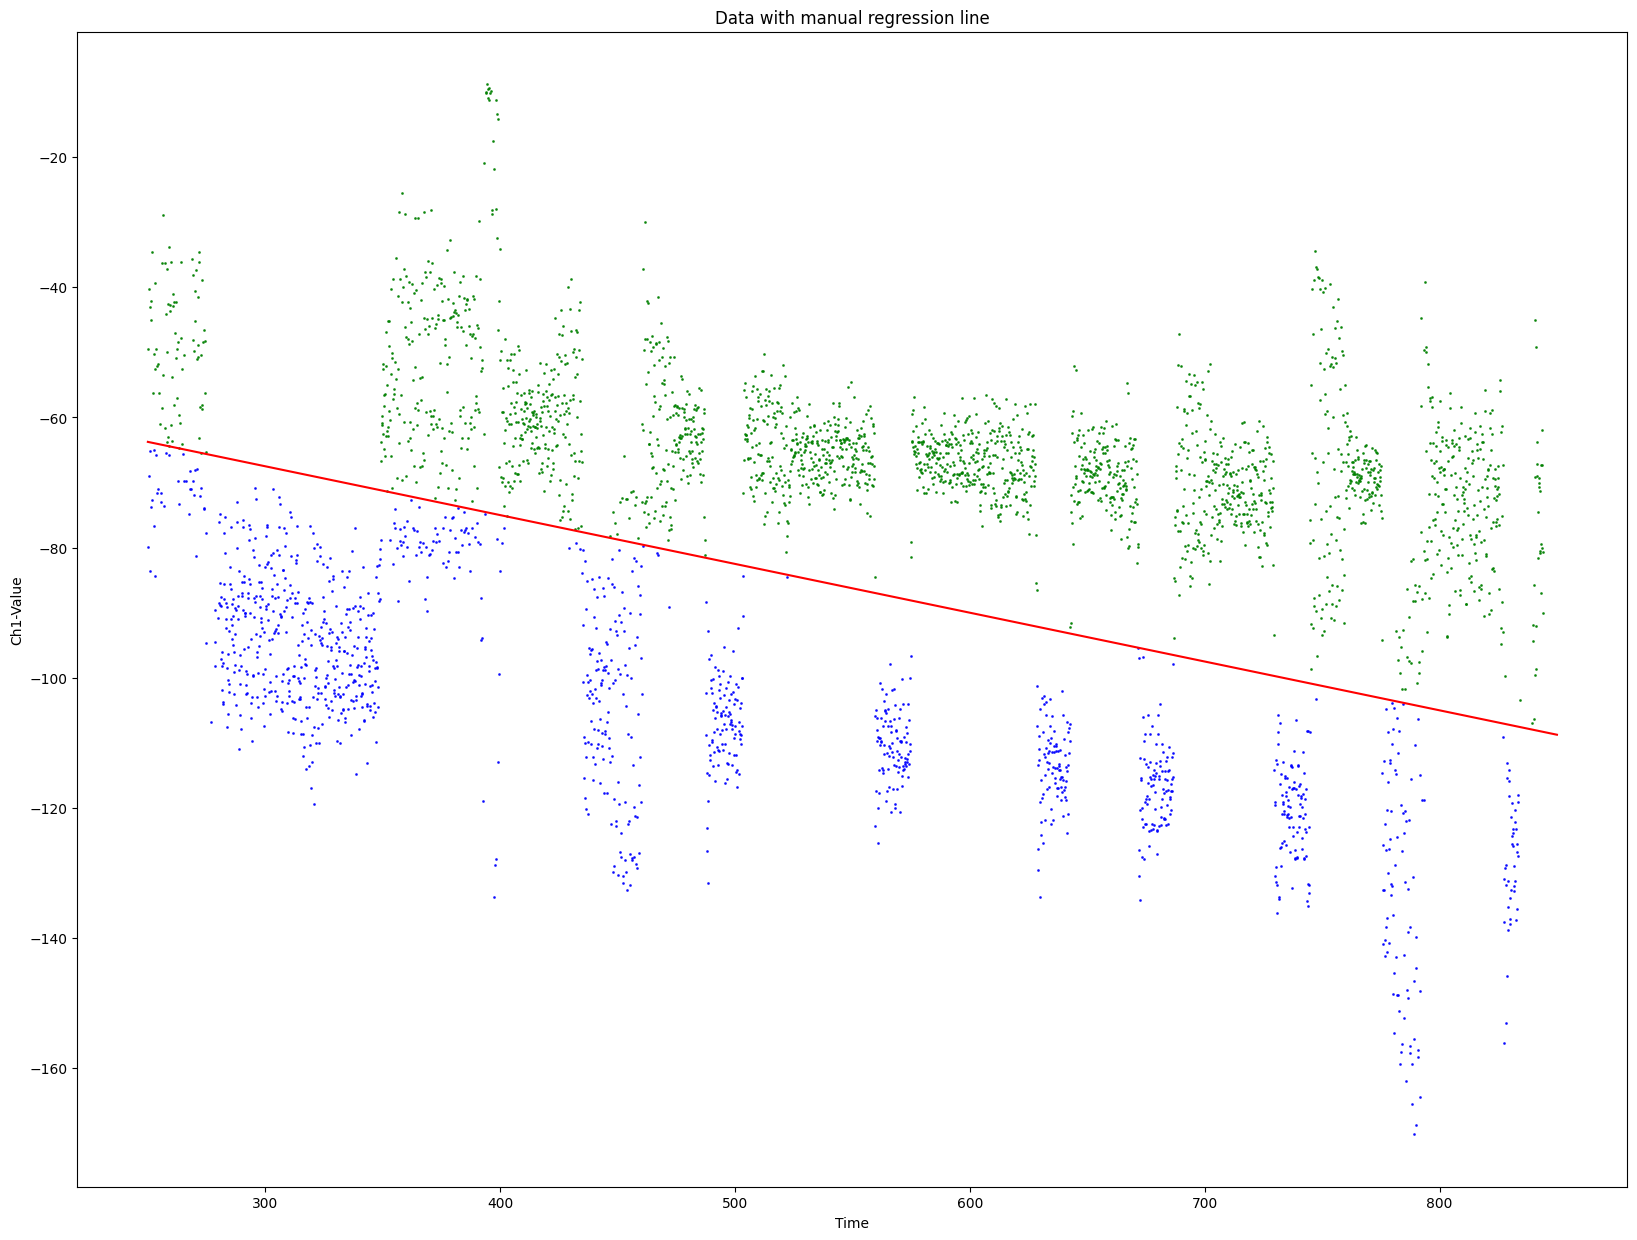

In [17]:
plt.figure(figsize=(20, 15))

#visualize data and regression line
plt.scatter(above_line_filtered['Zeit'], above_line_filtered['Ch1'], color='green', alpha=0.8, s=1) # scatter plot of points above regression line
plt.scatter(below_line_filtered['Zeit'], below_line_filtered['Ch1'], color='blue', alpha=0.8, s=1) # scatter plot of points below regression line
plt.plot(df['Zeit'], slope * df['Zeit'] + intercept, color='red') # line plot of regression line

plt.title("Data with manual regression line")
plt.xlabel("Time")
plt.ylabel("Ch1-Value")
plt.show()

# If you're happy with the plot, run this assignment
above_line = above_line_filtered
below_line = below_line_filtered

In [18]:
# computes confidence interval for 95%
def regression_ci(x, y, degree, ci=95):
    """
    Compute the confidence interval for a polynomial regression
    of degree `degree` fit to the data `x` and `y` at the given
    `ci` level of confidence.
    
    Returns a tuple (coeffs, lower, upper) where coeffs are the
    polynomial coefficients, lower and upper are vectors giving
    the lower and upper bounds of the confidence interval at
    each `x` value.
    """
    coeffs = np.polyfit(x, y, degree)
    line_function = np.poly1d(coeffs)
    
    # compute predicted values and standard error
    y_hat = line_function(x)
    resid = y - y_hat
    df = x.size - (degree + 1)
    mse = np.sum(resid ** 2) / df
    se = np.sqrt(mse * (1 + 1/x.size + (x - np.mean(x)) ** 2 / np.sum((x - np.mean(x)) ** 2)))
    
    # compute confidence bounds
    alpha = 1 - ci / 100
    tval = np.abs(stats.t.ppf(alpha/2, df))
    lower = line_function(x) - tval * se
    upper = line_function(x) + tval * se
    
    return coeffs, lower, upper

/home/nya/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3378: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/tmp/ipykernel_2023/2956102318.py:23: RankWarning: Polyfit may be poorly conditioned
  coeffs, lower, upper = regression_ci(sorted_data['RPM-Value-Motor'], sorted_data['Ch1'], 10, ci=95)


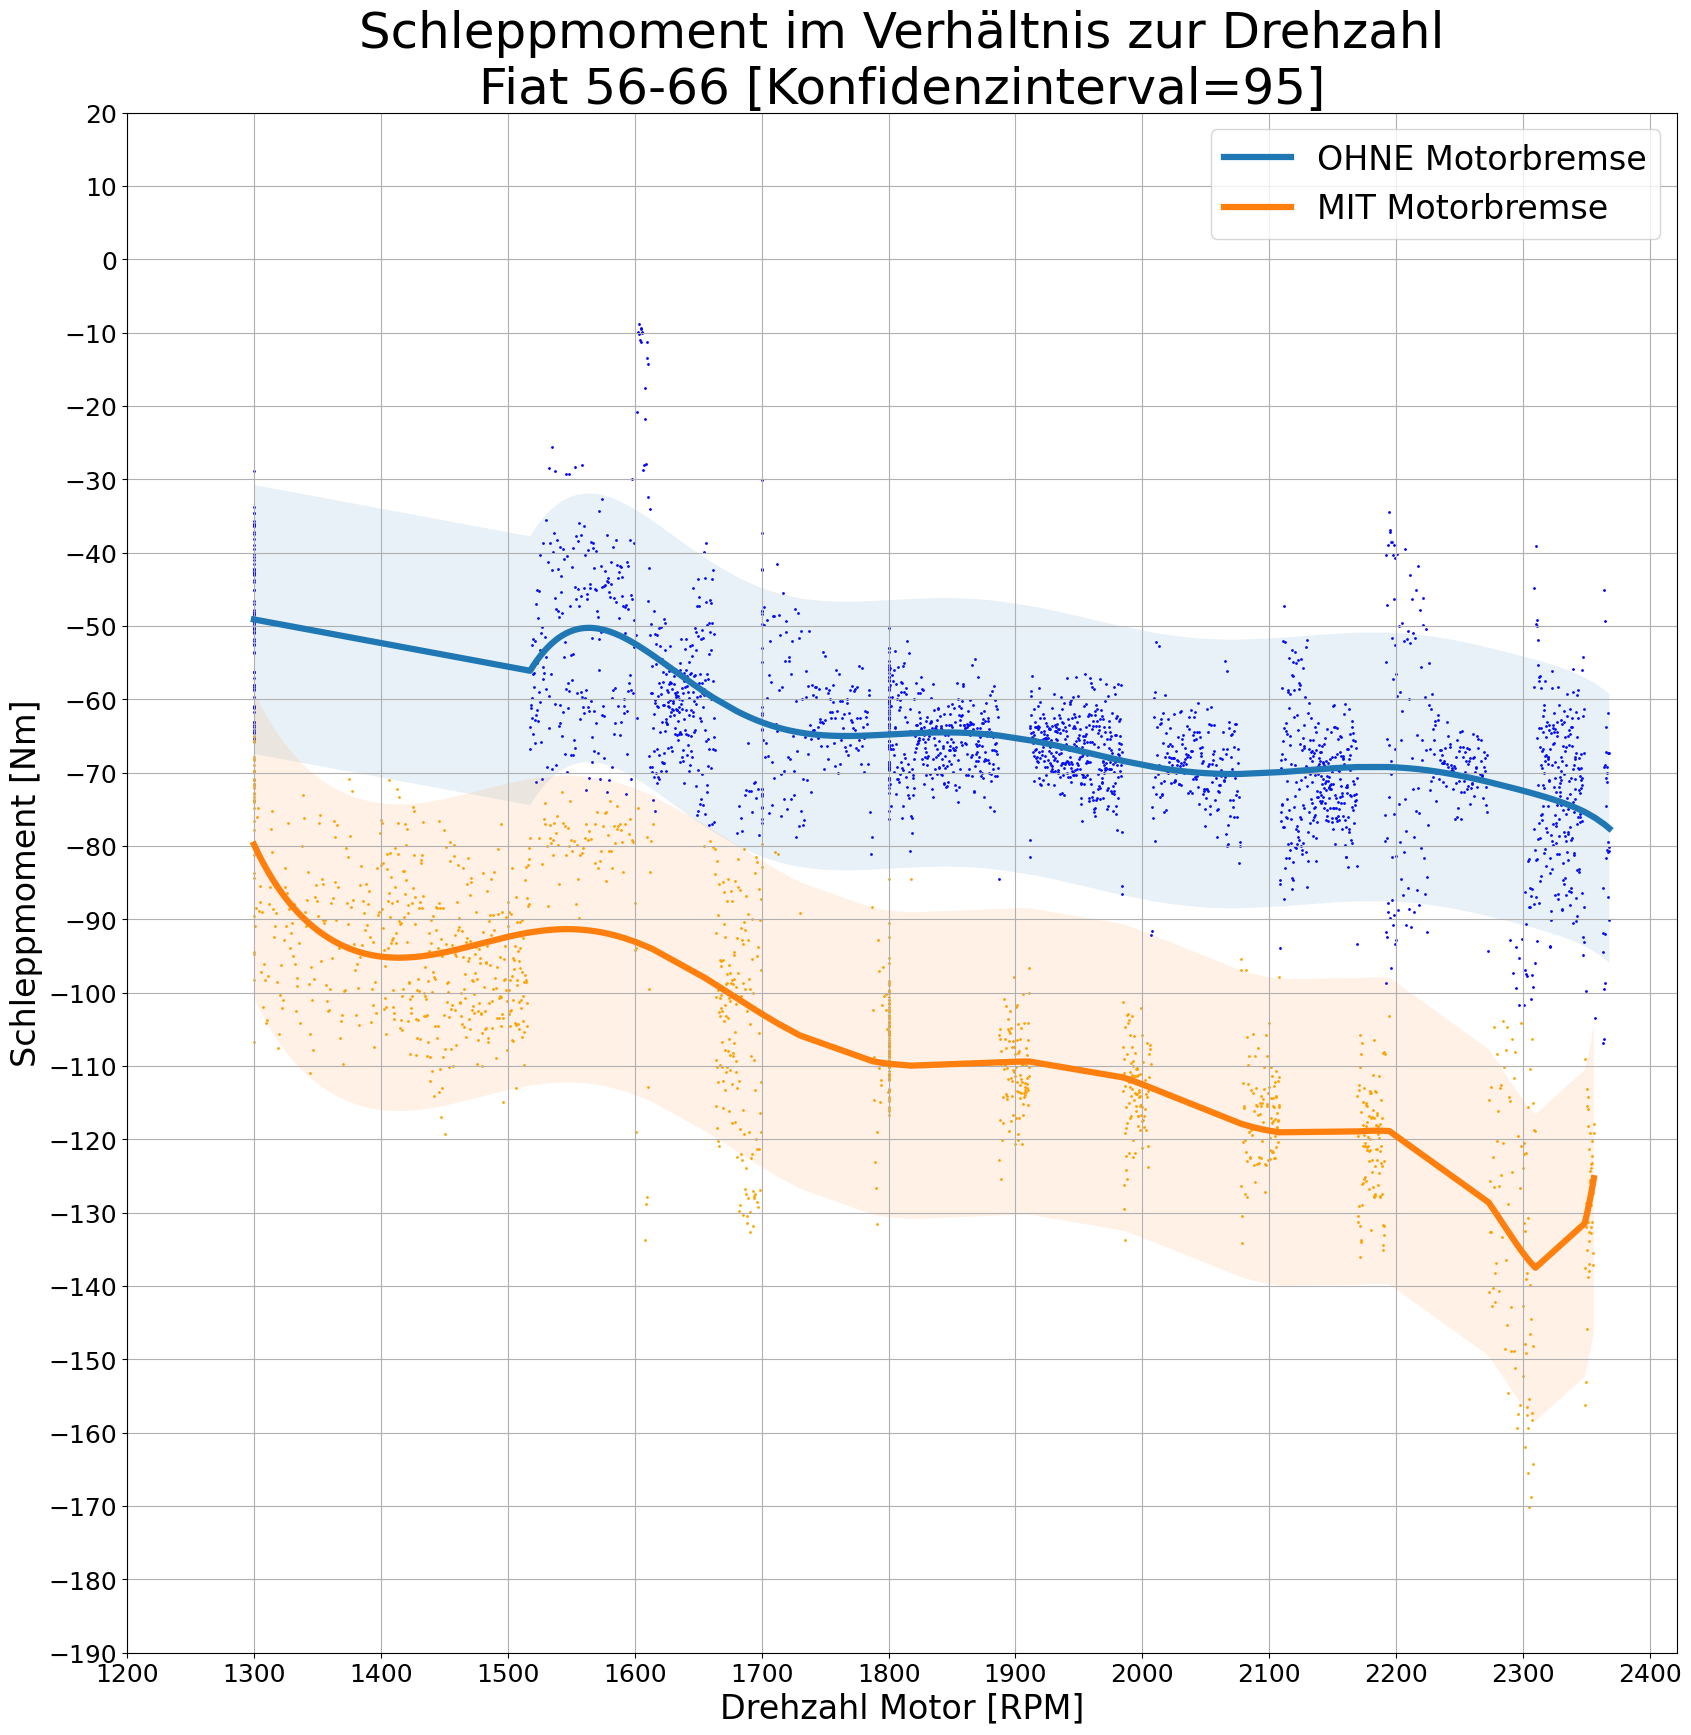

In [19]:
plt.figure(figsize=(20, 20))

# show all points
plt.scatter(data=above_line, x='RPM-Value-Motor', y='Ch1', color='blue', alpha=1, s=1, label='')
plt.scatter(data=below_line, x='RPM-Value-Motor', y='Ch1', color='orange', alpha=1, s=1, label='')

# automatically add the first few points from the OHNE dataset to the MIT,
# as MIT has the same "schleppmomentum" when no "motorbremse" is available at low RPM
min_rpm = below_line['RPM-Value-Motor'].min()
rows_to_prepend = above_line[above_line['RPM-Value-Motor'] < min_rpm]
below_line = pd.concat([rows_to_prepend, below_line], ignore_index=True)

# # # fit and plot regression lines above_line and below_line
for name, data in [('OHNE Motorbremse', above_line), ('MIT Motorbremse', below_line)]:
    # fit linear regression
    sorted_data = data.sort_values(by='RPM-Value-Motor')
    coefficients = np.polyfit(sorted_data['RPM-Value-Motor'], sorted_data['Ch1'], 10)
    line_function = np.poly1d(coefficients)
    # plot line with label
    # sns.lineplot(x=data['RPM-Value-Motor'], y=y_values, label=f'{name}', linewidth=4.5)
    plt.plot(sorted_data['RPM-Value-Motor'], line_function(sorted_data['RPM-Value-Motor']), label=f'{name}', linewidth=4.5)

    coeffs, lower, upper = regression_ci(sorted_data['RPM-Value-Motor'], sorted_data['Ch1'], 10, ci=95)
#     line_function = np.poly1d(coeffs)
    # plot confidence interval
    plt.fill_between(sorted_data['RPM-Value-Motor'], lower, upper, alpha=0.1)

# # set labels and title
plt.xlabel('Drehzahl Motor [RPM]', fontsize=24)
plt.ylabel('Schleppmoment [Nm]', fontsize=24)
plt.title(f"Schleppmoment im Verhältnis zur Drehzahl\n{names[TRACTOR]} [Konfidenzinterval=95]", fontsize=36)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
# Set tick positions on the y-axis on divisible by 10
ystart = np.ceil(below_line['Ch1'].min()/10) * 10 - 30 # - 50
yend = np.ceil(above_line['Ch1'].max()/10) * 10 + 50
plt.yticks(np.arange(ystart + 10, yend - 20, 10))
# # Set tick positions on the x-axis
xstart = np.ceil(df['RPM-Value-Motor'].min()/100) * 100
xend = np.ceil(df['RPM-Value-Motor'].max()/100) * 100
plt.xticks(np.arange(xstart - 100, xend + 100, 100))
plt.grid(which='both')
plt.legend(loc=1, fontsize=24)

plt.ion()
plt.savefig(f"graphs/schlepp_{TRACTOR}.png")

### Vollast miteinbezogen

In [20]:
volllast = pd.read_csv(files2[TRACTOR], sep="\t")
volllast.rename(columns={'RPM': 'RPM-Value-Motor', 'Drehmoment[Nm]': 'Ch1'}, inplace=True)
sorted_volllast = volllast.sort_values(by='RPM-Value-Motor')

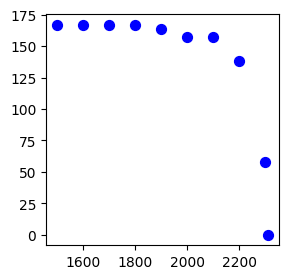

In [21]:
plt.figure(figsize=(3, 3))
plt.scatter(data=sorted_volllast, x='RPM-Value-Motor', y='Ch1', color='blue', alpha=1, s=50, label='')
plt.show()

/home/nya/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3378: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/tmp/ipykernel_2023/3288519916.py:24: RankWarning: Polyfit may be poorly conditioned
  coeffs, lower, upper = regression_ci(sorted_data['RPM-Value-Motor'], sorted_data['Ch1'], 10, ci=95)
/home/nya/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3378: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/tmp/ipykernel_2023/3288519916.py:24: RankWarning: Polyfit may be poorly conditioned
  coeffs, lower, upper = regression_ci(sorted_data['RPM-Value-Motor'], sorted_data['Ch1'], 10, ci=95)
/home/nya/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


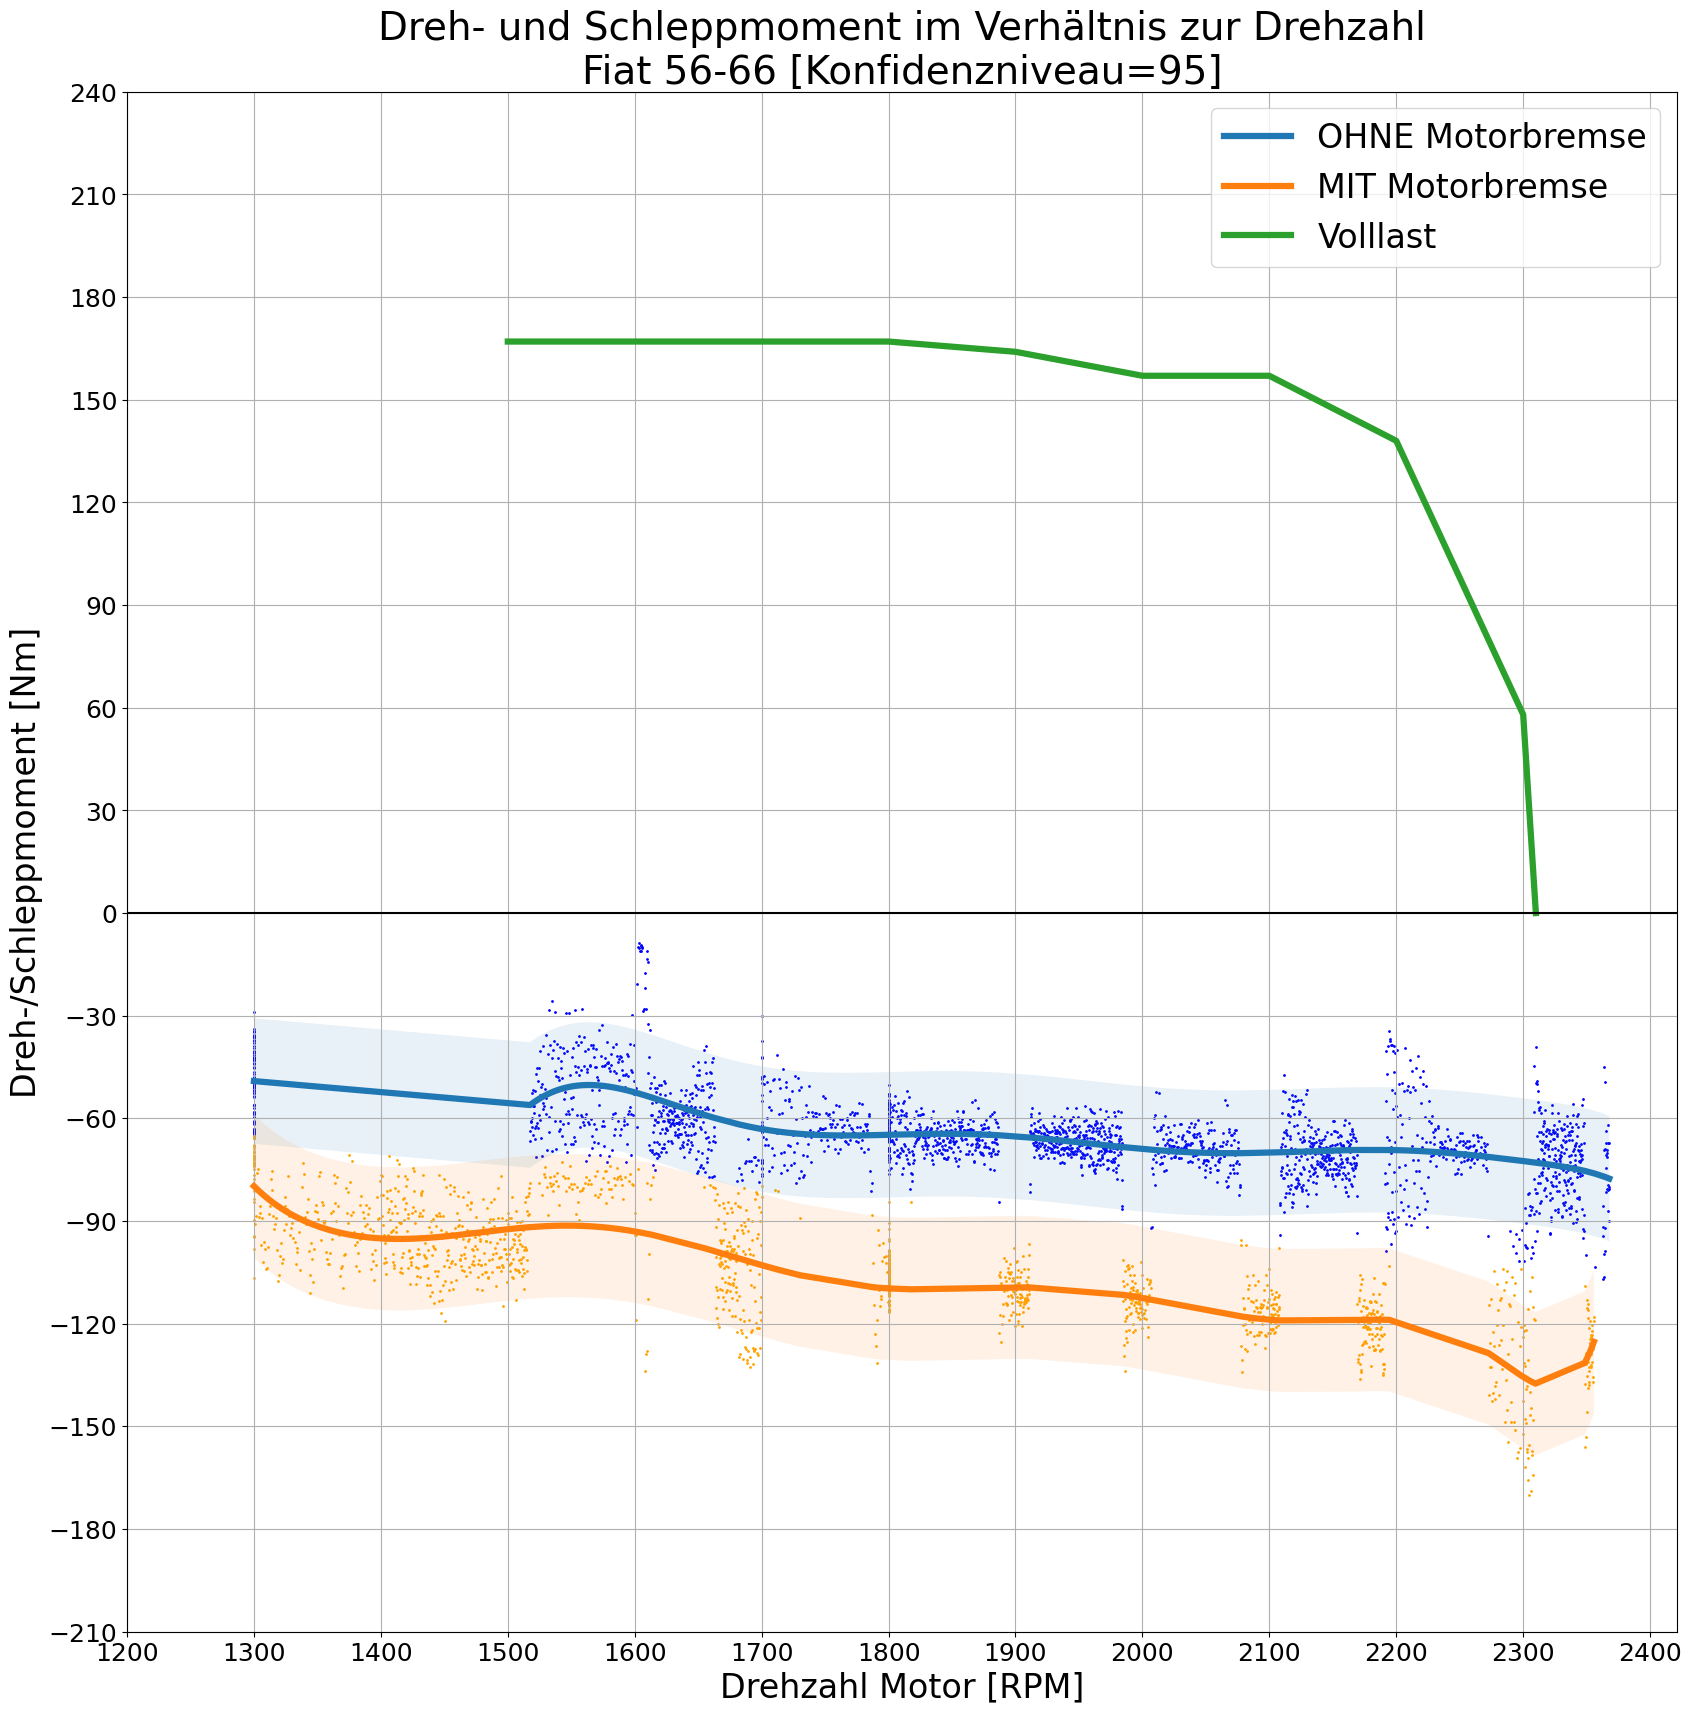

In [22]:
plt.figure(figsize=(20, 20))

# show all points
plt.scatter(data=above_line, x='RPM-Value-Motor', y='Ch1', color='blue', alpha=1, s=1, label='')
plt.scatter(data=below_line, x='RPM-Value-Motor', y='Ch1', color='orange', alpha=1, s=1, label='')
plt.scatter(data=sorted_volllast, x='RPM-Value-Motor', y='Ch1', color='green', alpha=1, s=1, label='')

# automatically add the first few points from the OHNE dataset to the MIT,
# as MIT has the same "schleppmomentum" when no "motorbremse" is available at low RPM
min_rpm = below_line['RPM-Value-Motor'].min()
rows_to_prepend = above_line[above_line['RPM-Value-Motor'] < min_rpm]
below_line = pd.concat([rows_to_prepend, below_line], ignore_index=True)

# # fit and plot regression lines above_line and below_line
for name, data in [('OHNE Motorbremse', above_line), ('MIT Motorbremse', below_line), ('Volllast', volllast)]:
    # fit linear regression
    sorted_data = data.sort_values(by='RPM-Value-Motor')
    coefficients = np.polyfit(sorted_data['RPM-Value-Motor'], sorted_data['Ch1'], 10)
    line_function = np.poly1d(coefficients)
    # plot line with label
    # sns.lineplot(x=data['RPM-Value-Motor'], y=y_values, label=f'{name}', linewidth=4.5)
    plt.plot(sorted_data['RPM-Value-Motor'], line_function(sorted_data['RPM-Value-Motor']), label=f'{name}', linewidth=4.5)

    coeffs, lower, upper = regression_ci(sorted_data['RPM-Value-Motor'], sorted_data['Ch1'], 10, ci=95)
    # plot confidence interval
    plt.fill_between(sorted_data['RPM-Value-Motor'], lower, upper, alpha=0.1)

plt.axhline(y=0, color='black', linewidth=1.5)

# # set labels and title
plt.xlabel('Drehzahl Motor [RPM]', fontsize=24)
plt.ylabel('Dreh-/Schleppmoment [Nm]', fontsize=24)
plt.title(f"Dreh- und Schleppmoment im Verhältnis zur Drehzahl\n{names[TRACTOR]} [Konfidenzniveau=95]", fontsize=28)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
# Set tick positions on the y-axis on divisible by 10
ystart = np.ceil(below_line['Ch1'].min()/10) * 10 - 50
yend = np.ceil(volllast['Ch1'].max()/10) * 10 + 100
plt.yticks(np.arange(ystart + 10, yend - 20, 30))
# # Set tick positions on the x-axis
xstart = np.ceil(above_line['RPM-Value-Motor'].min()/100) * 100
xend = np.ceil(max(above_line['RPM-Value-Motor'].max(), volllast['RPM-Value-Motor'].max())/100) * 100
plt.xticks(np.arange(xstart - 100, xend + 100, 100))
plt.grid(which='both')
plt.legend(loc=1, fontsize=24)

plt.ion()
plt.savefig(f"graphs/volllast_{TRACTOR}.png")